In [ ]:
import requests
import json
import time
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier, RandomForestRegressor
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import RFE, SelectKBest, f_regression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, roc_auc_score, auc, roc_curve, recall_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, TransformerMixin
from imblearn.ensemble import BalancedBaggingClassifier 
import numpy as np
from scipy import stats
import seaborn as sns
import tensorflow as tf
from sklearn import metrics
from datetime import datetime
import xgboost as xgb
import pickle

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
df = pd.read_csv('train.csv')
weather = pd.read_csv('weather.csv')
spray = pd.read_csv('spray.csv')
test = pd.read_csv('test.csv')

In [3]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 12 columns):
Date                      10506 non-null object
Address                   10506 non-null object
Species                   10506 non-null object
Block                     10506 non-null int64
Street                    10506 non-null object
Trap                      10506 non-null object
AddressNumberAndStreet    10506 non-null object
Latitude                  10506 non-null float64
Longitude                 10506 non-null float64
AddressAccuracy           10506 non-null int64
NumMosquitos              10506 non-null int64
WnvPresent                10506 non-null int64
dtypes: float64(2), int64(4), object(6)
memory usage: 985.0+ KB


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116293 entries, 0 to 116292
Data columns (total 11 columns):
Id                        116293 non-null int64
Date                      116293 non-null object
Address                   116293 non-null object
Species                   116293 non-null object
Block                     116293 non-null int64
Street                    116293 non-null object
Trap                      116293 non-null object
AddressNumberAndStreet    116293 non-null object
Latitude                  116293 non-null float64
Longitude                 116293 non-null float64
AddressAccuracy           116293 non-null int64
dtypes: float64(2), int64(3), object(6)
memory usage: 9.8+ MB


In [6]:
def clean_train_data(df):
    
    # map df dataset with weather dataset
    mask3 = np.power((df['Latitude']-41.995),2)+ np.power((df['Longitude']-(-87.933)),2) <= \
            np.power((df['Latitude']-41.786),2)+ np.power((df['Longitude']-(-87.752)),2)
    mask4 = np.power((df['Latitude']-41.995),2)+ np.power((df['Longitude']-(-87.933)),2) > \
            np.power((df['Latitude']-41.786),2)+ np.power((df['Longitude']-(-87.752)),2)
    df.loc[mask3,'weather_station'] = 1
    df.loc[mask4,'weather_station'] = 2
    df_weather = df.join(weather.set_index(['Date','Station']), on=(['Date','weather_station']), how='left')
    
    # map df_weather dataset with spray dataset
    date_format = "%Y-%m-%d"
    date_formated_df = []
    date_formated_spray = []
    for i in df_weather['Date']:
        date_formated_df.append(datetime.strptime(i, date_format))
    for i in spray['Date']:
        date_formated_spray.append(datetime.strptime(i, date_format))
    date_formated_spray = set(date_formated_spray)
    date_formated_spray = list(date_formated_spray)
    days_after_spray = []
    for i in date_formated_df:
        delta = []
        for n in date_formated_spray:
            if (i - n).days > 0:
                delta.append((i - n).days)
        if len(delta) != 0:
            days = np.min(delta)
        else:
            days = 0
        days_after_spray.append(days)
    df_weather['days_after_spray'] = days_after_spray

    ## deal with the missing value of the useful columns
    mask5 = (df_weather.PrecipTotal == '  T')| (df_weather.PrecipTotal =='M')
    mask6 = df_weather.WetBulb == 'M'
    mask7 = df_weather.StnPressure == 'M'
    df_weather.loc[mask5,'PrecipTotal'] = 0.00
    df_weather.loc[mask6,'WetBulb'] = round((df_weather[df_weather.WetBulb!='M']['WetBulb']).astype('int').mean())
    df_weather.loc[mask7,'StnPressure'] = round((df_weather[df_weather.StnPressure!='M']['StnPressure']).astype('float').mean(),2)
    
    #create columns for light and heavy rain day off and within 14 days 
    df_weather['PrecipTotal'] = df_weather['PrecipTotal'].astype(float)
    precip_75quantile = df_weather[df_weather['PrecipTotal'] > 0]['PrecipTotal'].quantile(.75)
    precip_25quantile = df_weather[df_weather['PrecipTotal'] > 0]['PrecipTotal'].quantile(.25)

    df_weather['heavy_rain'] = (df_weather['PrecipTotal']>precip_75quantile).astype(int)
    df_weather['light_rain'] = ((df_weather['PrecipTotal']>0) & (df_weather['PrecipTotal']<precip_25quantile)).astype(int)

    for i in range(1,15):
        df_weather['light_rain_past' + str(i)] = df_weather['light_rain'].shift(periods=i)
        df_weather['heavy_rain_past' + str(i)] = df_weather['heavy_rain'].shift(periods=i)
    
    #create column if it rained in the past 14 days 
    df_weather['heavy_rain_last_14_days'] = np.where(df_weather[['heavy_rain_past1', 'heavy_rain_past2',
       'heavy_rain_past3', 'heavy_rain_past4', 'heavy_rain_past5',
       'heavy_rain_past6', 'heavy_rain_past7', 'heavy_rain_past8',
       'heavy_rain_past9', 'heavy_rain_past10', 'heavy_rain_past11',
       'heavy_rain_past12', 'heavy_rain_past13', 'heavy_rain_past14']].any(axis=1), 1, 0)

    df_weather['light_reain_last_14_days'] = np.where(df_weather[['light_rain_past1', 'light_rain_past2',
       'light_rain_past3', 'light_rain_past4', 'light_rain_past5',
       'light_rain_past6', 'light_rain_past7', 'light_rain_past8',
       'light_rain_past9', 'light_rain_past10', 'light_rain_past11',
       'light_rain_past12', 'light_rain_past13', 'light_rain_past14',]].any(axis=1), 1, 0)
    
    # clean up the total dataset 
    df_total = df_weather
    
    #fix NumMosquitos column
    df_total['NumMosquitos_sum'] = np.nan #create sum column
    #fill sum column with sum of matching rows
    df_total['NumMosquitos_sum'].fillna(df_total.groupby(['Date','Trap','Species'])['NumMosquitos'].transform('sum'), inplace=True)
    df_total.drop(['NumMosquitos'], axis=1, inplace=True) #drop old column
    df_total.drop_duplicates(inplace=True) #drop duplicated rows 
    df_total.reset_index(inplace=True) #reset index 
    
    #create ordinal date column
    df_total['Date'] = pd.to_datetime(df_total['Date'])
    df_total['ordinal_date'] = df_total['Date'].map(lambda x: x.toordinal())
    
    #create month/day for time of year 
    df_total['month_day'] = df_total['Date'].dt.month + df_total['Date'].map(lambda x: .5 if x.day > 15 else 0)
    
    df_total['Trap'] = df_total['Trap'].str.extract('(\d\d\d)').astype(int)
    
    ## drop useless columns
    ## different for train and test dataset because test data doesn't include 'NumMosquitos' column
    ## and test data has "Id" column that need to be dropped
    
    df_total = df_total.drop(['Date','Address','Block','Street','AddressNumberAndStreet',\
              'AddressAccuracy','weather_station','Depart','CodeSum','Depth',\
              'Water1','SnowFall', 'Sunrise', 'Sunset', 'index'],axis=1)
              # NumMosquitos and CodeSum may still helpful (test data doesn't include 'NumMosquitos' column)
              #**changed this to keep NumMosquitos
    
    ## change the datatype to correct one
    df_total[['Tavg','WetBulb','Heat','Cool']] = df_total[['Tavg','WetBulb','Heat','Cool']].astype(int)
    df_total[['PrecipTotal','StnPressure','SeaLevel','AvgSpeed']] = \
    df_total[['PrecipTotal','StnPressure','SeaLevel','AvgSpeed']].astype(float)
    
    #computer rolling averages 
    for i in [3,5,10,14,21,30]: #set intervals for rolling average calculation
        for j in ['Tmax', 'Tmin', 'Tavg', 'DewPoint', 'WetBulb', 'Heat', 'Cool',    #columns to compute rolling averages for
                  'PrecipTotal', 'StnPressure', 'SeaLevel','ResultSpeed', 'ResultDir', 'AvgSpeed']:
            df_total[j + str(i)] = df_total[j].rolling(window=i, min_periods=int(i/5)).mean() #create column with interval for each computation
                                                                                #min_periods allows for computing these and not getting NaN values
                                                                                #for reasonable amount of missing data
    ## dummy the object variable
    df_total = pd.get_dummies(df_total,drop_first=True,columns=['Species', 'month_day'])
    
    #drop'month_day_6.0', not in test data 
    df_total.drop(['month_day_6.0'], axis=1, inplace=True)
    
    #fill na's
    df_total.fillna(method='backfill', inplace=True)
    
    
    # return cleaned dataframe

    return df_total

In [7]:
def clean_test_data(df):
    
    # map df dataset with weather dataset
    mask3 = np.power((df['Latitude']-41.995),2)+ np.power((df['Longitude']-(-87.933)),2) <= \
            np.power((df['Latitude']-41.786),2)+ np.power((df['Longitude']-(-87.752)),2)
    mask4 = np.power((df['Latitude']-41.995),2)+ np.power((df['Longitude']-(-87.933)),2) > \
            np.power((df['Latitude']-41.786),2)+ np.power((df['Longitude']-(-87.752)),2)
    df.loc[mask3,'weather_station'] = 1
    df.loc[mask4,'weather_station'] = 2
    df_weather = df.join(weather.set_index(['Date','Station']), on=(['Date','weather_station']), how='left')

    # map df_weather dataset with spray dataset
    date_format = "%Y-%m-%d"
    date_formated_df = []
    date_formated_spray = []
    for i in df_weather['Date']:
        date_formated_df.append(datetime.strptime(i, date_format))
    for i in spray['Date']:
        date_formated_spray.append(datetime.strptime(i, date_format))
    date_formated_spray = set(date_formated_spray)
    date_formated_spray = list(date_formated_spray)
    days_after_spray = []
    for i in date_formated_df:
        delta = []
        for n in date_formated_spray:
            if (i - n).days > 0:
                delta.append((i - n).days)
        if len(delta) != 0:
            days = np.min(delta)
        else:
            days = 0
        days_after_spray.append(days)
    df_weather['days_after_spray'] = days_after_spray
    
    ## deal with the missing value of the useful columns
    mask5 = (df_weather.PrecipTotal == '  T')| (df_weather.PrecipTotal =='M')
    mask6 = df_weather.WetBulb == 'M'
    mask7 = df_weather.StnPressure == 'M'
    df_weather.loc[mask5,'PrecipTotal'] = 0.00
    df_weather.loc[mask6,'WetBulb'] = round((df_weather[df_weather.WetBulb!='M']['WetBulb']).astype('int').mean())
    df_weather.loc[mask7,'StnPressure'] = round((df_weather[df_weather.StnPressure!='M']['StnPressure']).astype('float').mean(),2)
    
    #create columns for light and heavy rain day off and within 14 days 
    df_weather['PrecipTotal'] = df_weather['PrecipTotal'].astype(float)
    precip_75quantile = df_weather[df_weather['PrecipTotal'] > 0]['PrecipTotal'].quantile(.75)
    precip_25quantile = df_weather[df_weather['PrecipTotal'] > 0]['PrecipTotal'].quantile(.25)

    df_weather['heavy_rain'] = (df_weather['PrecipTotal']>precip_75quantile).astype(int)
    df_weather['light_rain'] = ((df_weather['PrecipTotal']>0) & (df_weather['PrecipTotal']<precip_25quantile)).astype(int)

    for i in range(1,15):
        df_weather['light_rain_past' + str(i)] = df_weather['light_rain'].shift(periods=i)
        df_weather['heavy_rain_past' + str(i)] = df_weather['heavy_rain'].shift(periods=i)
    
    #create column if it rained in the past 14 days 
    df_weather['heavy_rain_last_14_days'] = np.where(df_weather[['heavy_rain_past1', 'heavy_rain_past2',
       'heavy_rain_past3', 'heavy_rain_past4', 'heavy_rain_past5',
       'heavy_rain_past6', 'heavy_rain_past7', 'heavy_rain_past8',
       'heavy_rain_past9', 'heavy_rain_past10', 'heavy_rain_past11',
       'heavy_rain_past12', 'heavy_rain_past13', 'heavy_rain_past14']].any(axis=1), 1, 0)

    df_weather['light_reain_last_14_days'] = np.where(df_weather[['light_rain_past1', 'light_rain_past2',
       'light_rain_past3', 'light_rain_past4', 'light_rain_past5',
       'light_rain_past6', 'light_rain_past7', 'light_rain_past8',
       'light_rain_past9', 'light_rain_past10', 'light_rain_past11',
       'light_rain_past12', 'light_rain_past13', 'light_rain_past14',]].any(axis=1), 1, 0)
    
    # clean up the total dataset 
    df_total = df_weather
    
    #create ordinal date column
    df_total['Date'] = pd.to_datetime(df_total['Date'])
    df_total['ordinal_date'] = df_total['Date'].map(lambda x: x.toordinal())
    
    #create month/day for time of year 
    df_total['month_day'] = df_total['Date'].dt.month + df_total['Date'].map(lambda x: .5 if x.day > 15 else 0)
    
    ## drop useless columns
    ## different for train and test dataset because test data doesn't include 'NumMosquitos' column
    ## and test data has "Id" column that need to be dropped
    
    ### for train dataset
#     df_total = df_total.drop(['Date','Address','Block','Street','Trap','AddressNumberAndStreet',\
#               'AddressAccuracy','weather_station','Depart','CodeSum','Depth',\
#               'Water1','SnowFall','Sunrise','Sunset','NumMosquitos'],axis=1)
                 
                 # NumMosquitos and CodeSum may still helpful (test data doesn't include 'NumMosquitos' column)
    df_total['Trap'] = df_total['Trap'].str.extract('(\d\d\d)').astype(int)
    ### for test dataset
    df_total = df_total.drop(['Id','Date','Address','Block','Street','AddressNumberAndStreet',\
               'AddressAccuracy','weather_station','Depart','CodeSum','Depth',\
               'Water1','SnowFall','Sunrise','Sunset'],axis=1)
    
    
    ## change the datatype to correct one
    df_total[['Tavg','WetBulb','Heat','Cool']] = df_total[['Tavg','WetBulb','Heat','Cool']].astype(int)
    df_total[['PrecipTotal','StnPressure','SeaLevel','AvgSpeed']] = \
    df_total[['PrecipTotal','StnPressure','SeaLevel','AvgSpeed']].astype(float)
    
    #computer rolling averages 
    for i in [3,5,10,14,21,30]: #set intervals for rolling average calculation
        for j in ['Tmax', 'Tmin', 'Tavg', 'DewPoint', 'WetBulb', 'Heat', 'Cool',    #columns to compute rolling averages for
                  'PrecipTotal', 'StnPressure', 'SeaLevel','ResultSpeed', 'ResultDir', 'AvgSpeed']:
            df_total[j + str(i)] = df_total[j].rolling(window=i, min_periods=int(i/5)).mean() #create column with interval for each computation
                                                                                #min_periods allows for computing these and not getting NaN values
                                                                                #for reasonable amount of missing data
    #fill na's
    df_total.fillna(method='backfill', inplace=True)

    ## dummy the object variable
    df_total = pd.get_dummies(df_total,drop_first=True,columns=['Species', 'month_day'])
    
    
    ## drop one of the dummy variable 'Species_UNSPECIFIED CULEX' that train dataset doesn't have
    df_total = df_total.drop(['Species_UNSPECIFIED CULEX'],axis=1)
    
    # create polynomial features
    
    ## for train dataset
#     y = df_total['WnvPresent']
#     X = df_total.drop('WnvPresent',axis=1)
#     X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.15)
#     poly = PolynomialFeatures(include_bias=False,degree=2)
#     X_train_poly = poly.fit_transform(X_train)
#     X_test_poly = poly.transform(X_test)
#     X_train=pd.DataFrame(X_train_poly,columns=poly.get_feature_names(X_train.columns))
#     X_test=pd.DataFrame(X_test_poly,columns=poly.get_feature_names(X_test.columns))
    
    ## for test dataset
#     poly = PolynomialFeatures(include_bias=False,degree=2)
#     df_total_poly = poly.fit_transform(df_total)
#     df_total=pd.DataFrame(df_total_poly,columns=poly.get_feature_names(df_total.columns))
    
    # return cleaned dataframe
    
    ## for train dataset, return X_train and X_test data
#     return X_train, X_test
    
    ## for test dataset, return df_total
    return df_total

In [8]:
test_clean = clean_test_data(test)
test_clean.shape

/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:86: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)


(116293, 142)

In [9]:
train_clean = clean_train_data(df)
train_clean.shape

/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:84: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)


(8803, 144)

In [10]:
def humidity(Tf, Tdf):

    # convert temp to celsius
    Tc=5.0/9.0*(Tf-32.0)
    # convert dewpoint temp to celsius
    Tdc=5.0/9.0*(Tdf-32.0)
    # saturation vapor pressure
    Es=6.11*10.0**(7.5*Tc/(237.7+Tc))
    # actual vapor pressure
    E=6.11*10.0**(7.5*Tdc/(237.7+Tdc))
    #relative humidity
    RH =(E/Es)*100
        
    return RH

train_clean["RelHum"] = humidity(train_clean['Tavg'],train_clean['DewPoint'])
test_clean["RelHum"] = humidity(test_clean['Tavg'],test_clean['DewPoint'])

In [11]:
assert [cols for cols in train_clean.columns if cols not in test_clean.columns] == ['WnvPresent', 'NumMosquitos_sum']

In [12]:
train_clean['WnvPresent'].value_counts(normalize=True)

0    0.946723
1    0.053277
Name: WnvPresent, dtype: float64

# project nummosquitos

In [13]:
#create x and y columns for num mosquitos
col_list = ['NumMosquitos_sum', 'WnvPresent']
X_mos = train_clean[[cols for cols in train_clean.columns if cols not in col_list]]
y_mos = train_clean['NumMosquitos_sum']

#TTS
X_train_mos, X_test_mos, y_train_mos, y_test_mos = train_test_split(X_mos, y_mos, random_state=40, test_size=0.15)

In [15]:
pip_xgb = Pipeline([
    ('ss', StandardScaler()),
    ('xgb', xgb.XGBRegressor(reg_lambda=0))
    
])

params_xgb = {
    'xgb__n_estimators':[200, 250, 300],
    'xgb__learning_rate': [.01, .05, .1],
    'xgb__max_depth': [5,7,9],
    'xgb__reg_lambda': [3,5,7],
    'xgb__reg_alpha': [3,5,7]
}
gs2 = GridSearchCV(pip_xgb,param_grid=params_xgb)
gs2.fit(X_train_mos,y_train_mos)
print('best cv score', gs2.best_score_)
print('best paramas', gs2.best_params_)
print('test score', gs2.score(X_test_mos, y_test_mos))

best cv score 0.8454278029666006
best paramas {'xgb__learning_rate': 0.05, 'xgb__max_depth': 7, 'xgb__n_estimators': 300, 'xgb__reg_alpha': 3, 'xgb__reg_lambda': 5}
test score 0.7401121077580815


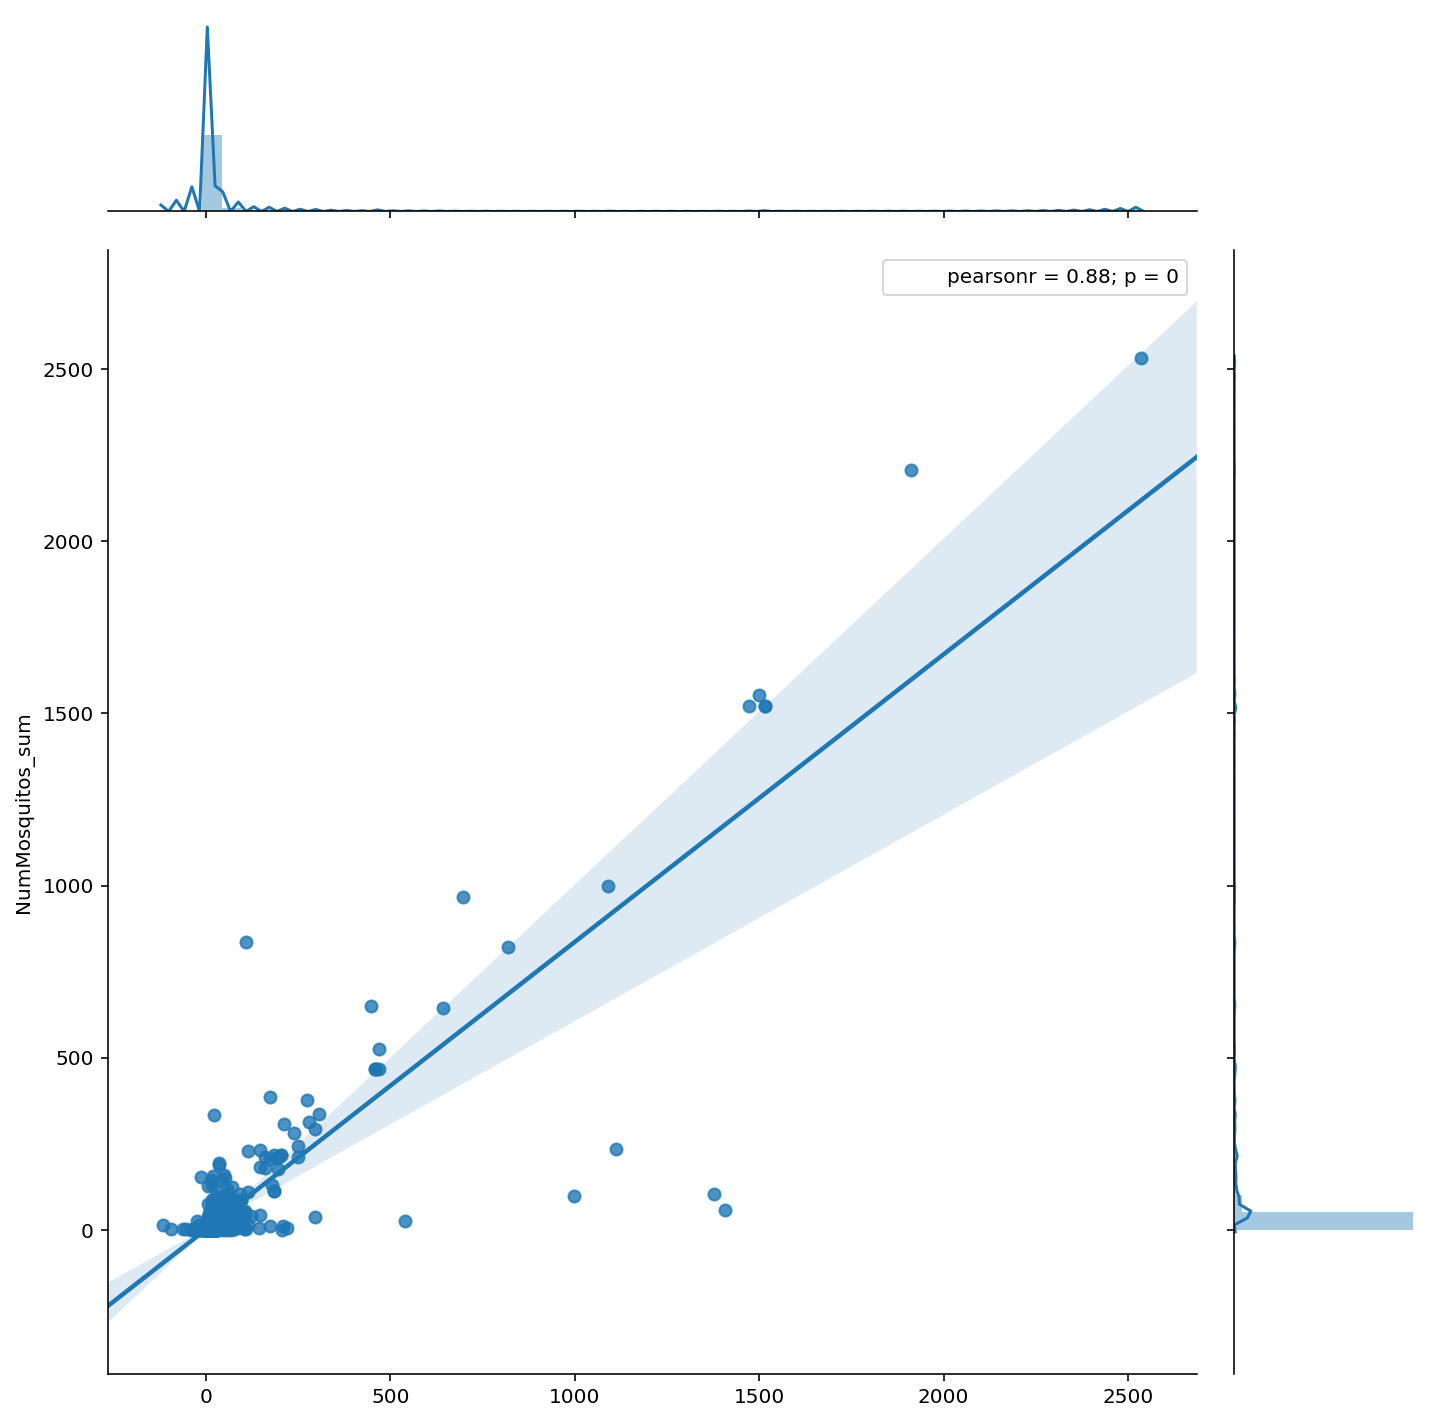

In [16]:
#plot predictions vs actual on test set 
test_predictions_mos = gs2.predict(X_test_mos)
sns.jointplot(test_predictions_mos, y_test_mos, kind='reg', data= train_clean, size=10);

In [17]:
#fit model on all training data
mos_model = gs2.best_estimator_
mos_model.fit(X_mos, y_mos)

Pipeline(memory=None,
     steps=[('ss', StandardScaler(copy=True, with_mean=True, with_std=True)), ('xgb', XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=7, min_child_weight=1, missing=None, n_estimators=300,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=3, reg_lambda=5, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))])

In [18]:
#predict mosquito counts for test data
test_clean['project_mos'] = mos_model.predict(test_clean)

In [29]:
#predict mosquito counts for train data 
train_predicitions = mos_model.predict(X_mos)
train_clean['project_mos'] = train_predicitions

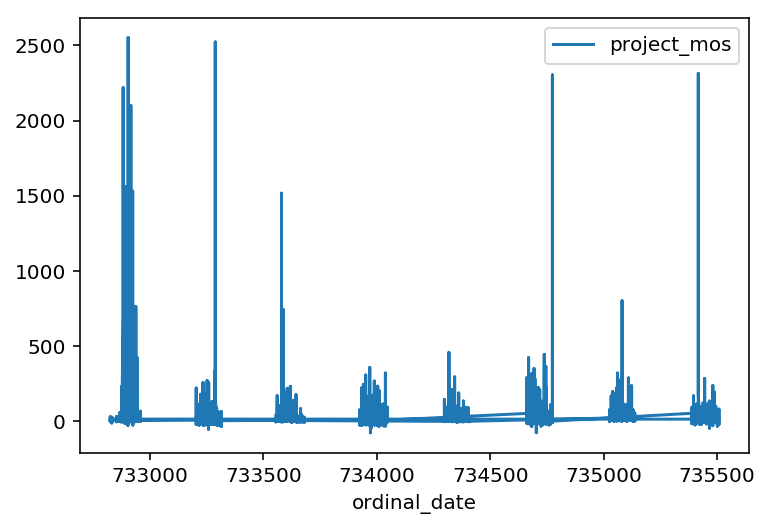

In [38]:
test_mos = test_clean[['project_mos', 'ordinal_date']]
train_mos = train_clean[['project_mos', 'ordinal_date']]
                    
mos_df = pd.concat([test_mos, train_mos])
mos_df.plot(x='ordinal_date', y='project_mos');

In [39]:
#pickle/unpickle model below and make predicitions
# modelfilename= 'mos_model2.sav'

In [40]:
# pickle.dump(mos_model, open(modelfilename, 'wb'))

In [ ]:
# loaded_model = pickle.load(open('mos_model2.sav', 'rb'))

In [ ]:
# loaded_model.score(X_test_mos, y_test_mos)

In [ ]:
# #predict mosquito counts for test data
# test_clean['project_mos'] = loaded_model.predict(test_clean)

In [ ]:
# #predict mosquito counts for train data 
# train_clean['project_mos'] = loaded_model.predict(train_clean)

### build the classficiation model

In [41]:
from sklearn.utils import resample

## Separate majority and minority classes
df_majority = train_clean[train_clean.WnvPresent==0]
df_minority = train_clean[train_clean.WnvPresent==1]
 
## Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=8334,    # to match majority class
                                 random_state=42) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled.WnvPresent.value_counts()

1    8334
0    8334
Name: WnvPresent, dtype: int64

In [42]:
y = df_upsampled['WnvPresent']
X = df_upsampled.drop(['WnvPresent', 'NumMosquitos_sum'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y, test_size=0.15)

In [43]:
# random forest is OK
pip1 = Pipeline([
    ('rf', RandomForestClassifier()) 
])
params1 = {
    'rf__n_estimators':[5,10,20],
    'rf__max_features': ["auto","sqrt","log2"],
    'rf__max_depth': [None,10,20]
}
gs3 = GridSearchCV(pip1,param_grid=params1)
gs3.fit(X_train,y_train)
print('best cv score', gs3.best_score_)
print('best paramas', gs3.best_params_)
print('test score', gs3.score(X_test, y_test))

best cv score 0.971130091056681
best paramas {'rf__max_depth': None, 'rf__max_features': 'sqrt', 'rf__n_estimators': 20}
test score 0.9772091163534586


In [44]:
# create a confusion matrix
y_hat = gs3.predict(X_test)
confusion_matrix(y_test,y_hat)

array([[1194,   57],
       [   0, 1250]])

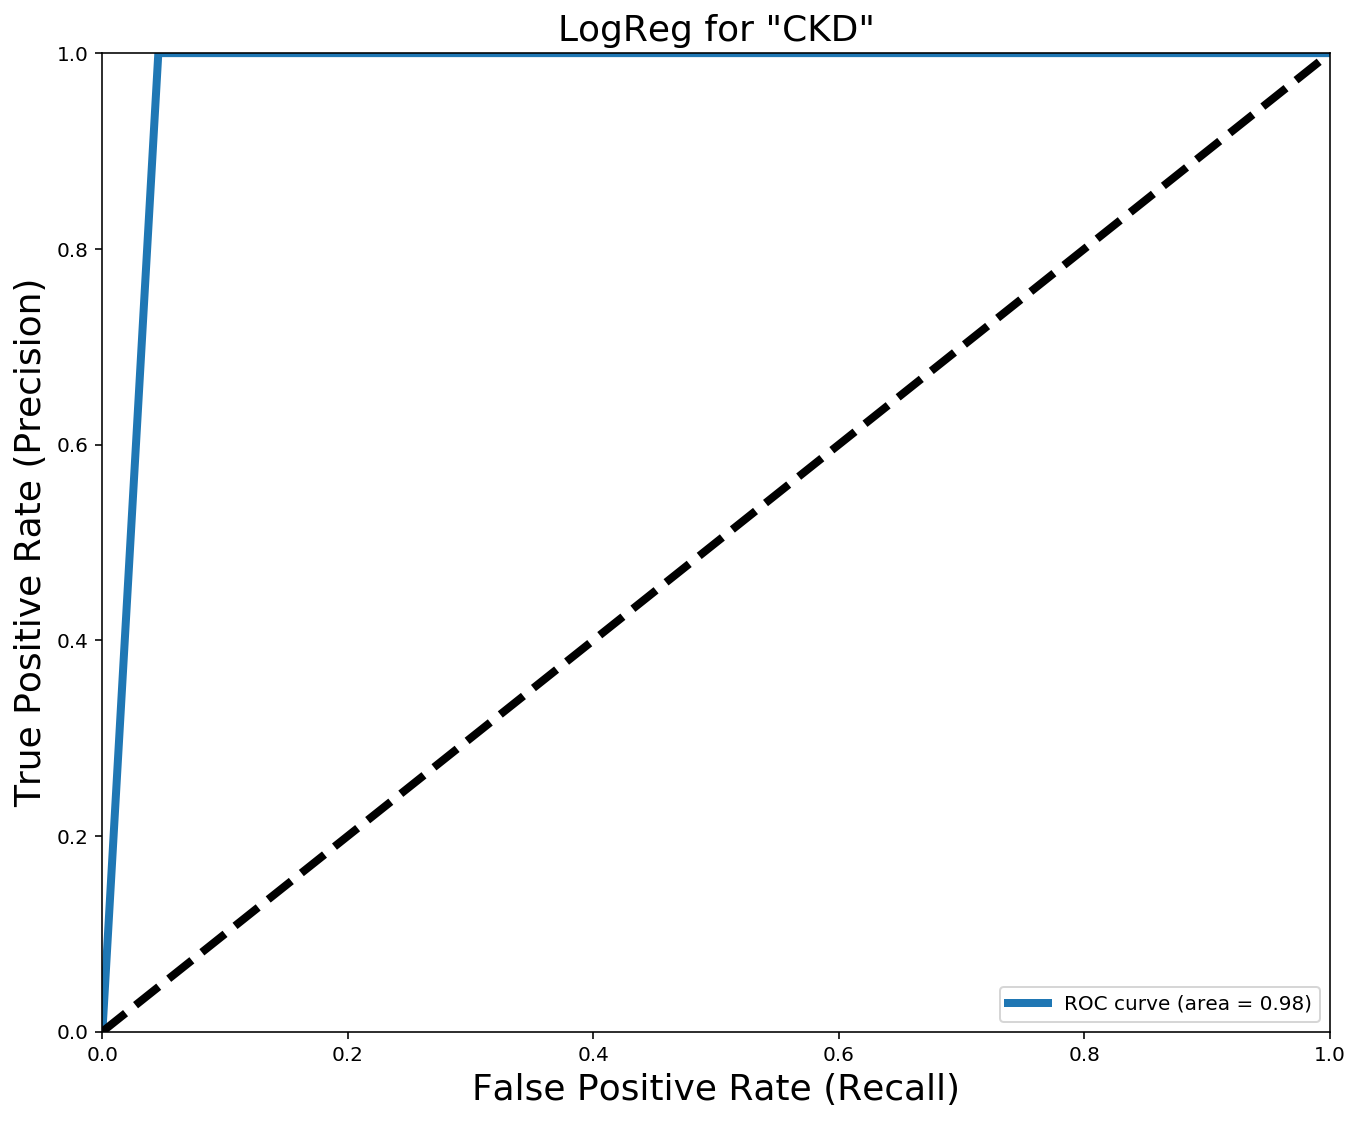

In [45]:
y_pred = gs3.predict(X_test)
FPR, TPR, threshold = roc_curve(y_test, y_pred)
ROC_AUC = auc(FPR, TPR)

plt.figure(figsize=[11,9])
plt.plot(FPR, TPR, label='ROC curve (area = %0.2f)' % ROC_AUC, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (Recall)', fontsize=18)
plt.ylabel('True Positive Rate (Precision)', fontsize=18)
plt.title('LogReg for "CKD"', fontsize=18)
plt.legend(loc="lower right")
plt.show()

In [46]:
gs3.fit(X, y)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'rf__n_estimators': [5, 10, 20], 'rf__max_features': ['auto', 'sqrt', 'log2'], 'rf__max_depth': [None, 10, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [47]:
test_clean.shape

(116293, 144)

In [48]:
test_pred = gs3.predict(test_clean)

In [49]:
test_pred.shape

(116293,)

In [50]:
test_pred = pd.DataFrame(test_pred)

In [51]:
test_pred['Id'] = [i for i in range(1,116294)]
test_pred['WnvPresent'] = test_pred[0]

In [52]:
test_pred.drop([0],axis=1,inplace=True)

In [53]:
test_pred.tail()

,Id,WnvPresent
116288,116289,0
116289,116290,0
116290,116291,0
116291,116292,0
116292,116293,0


In [54]:
test_pred['WnvPresent'].value_counts()

0    115910
1       383
Name: WnvPresent, dtype: int64

In [55]:
test_pred.to_csv('test_pred_17.csv',index=False)

In [56]:
# train test split 
y = train_clean['WnvPresent']
X = train_clean.drop(['WnvPresent', 'NumMosquitos_sum'], axis=1)


X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify = y,
                                                    random_state=42)


# Using RandomForestClassifier
rfc = RandomForestClassifier(random_state=19)
bbc = BalancedBaggingClassifier(base_estimator=rfc,
                                random_state=10)
bbc.fit(X_train,y_train)

bbc_predict = bbc.predict(X_test)
bbc_score = recall_score(y_test, bbc_predict)

print ("BBC Test Score:", bbc_score)

bbc_confusion = pd.DataFrame(np.array(confusion_matrix(y_test, bbc_predict)),
                         index = ['is_not_abnormal', 'is_abnormal'],
                        columns=['predicted_not_abnormal','predicted_abnormal'])
bbc_confusion

bbc_params = {
    'n_estimators':np.arange(5,20),
    'warm_start': [True, False]
#     'max_samples': [1,2]
#     'max_features': np.arange(1,10)
}

bbc_gs = GridSearchCV(bbc,
                     param_grid=bbc_params,
                     scoring='recall',
                     cv = 10)

bbc_gs.fit(X_train,y_train)
bbc_gs_score = bbc_gs.score(X_test, y_test)

print("Best Params: ", bbc_gs.best_params_)
print ("BBC Test Score:", bbc_gs_score)

BBC Test Score: 0.7777777777777778
Best Params:  {'n_estimators': 7, 'warm_start': True}
BBC Test Score: 0.7863247863247863


In [57]:
bbc_gs.fit(X,y)
test_pred2 = bbc_gs.predict(test_clean)
test_pred2 = pd.DataFrame(test_pred2)
test_pred2['Id'] = [i for i in range(1,116294)]
test_pred2['WnvPresent'] = test_pred2[0]
test_pred2.drop([0],axis=1,inplace=True)
test_pred2['WnvPresent'].value_counts()

0    109987
1      6306
Name: WnvPresent, dtype: int64

In [58]:
test_pred2.to_csv('test_pred_18.csv',index=False)

## Clean and Predict test data set

# additional models (optional)

In [ ]:
# # svm
# gamma_range = [0.001]
# C_range = [1]
# kernel_range = ['rbf', 'sigmoid', 'linear', 'poly']

# params3 = dict(gamma=gamma_range, kernel=kernel_range, C=C_range)

# clf = svm.SVC()
# gs3 = GridSearchCV(clf, params3, scoring="accuracy", verbose=0)
# gs3.fit(X_train,y_train)

In [ ]:
# print('best cv score', gs3.best_score_)
# print('best paramas', gs3.best_params_)
# print('test score', gs3.score(X_test, y_test))

In [ ]:
# # svm using unbalanced sample and use class_weight = 'WnvPresent' to penalize mistakes on the minority class 
# # by an amount proportional to how under-represented it is.
# y = train_clean['WnvPresent']
# X = train_clean.drop('WnvPresent',axis=1)
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.15)

# gamma_range = [0.001]
# C_range = [1]
# kernel_range = ['linear']
# class_weight=['balanced']

# params4 = dict(gamma=gamma_range, kernel=kernel_range, C=C_range, class_weight=class_weight)

# clf = svm.SVC()
# gs4 = GridSearchCV(clf, params4, scoring="accuracy", verbose=0)
# gs4.fit(X_train,y_train)

# print('best cv score', gs4.best_score_)
# print('best paramas', gs4.best_params_)
# print('test score', gs4.score(X_test, y_test))

In [ ]:
# # logistic regression is bad?
# pip2 = Pipeline([
#     ('ss', StandardScaler()), 
#     ('lr', LogisticRegression())
# ])
# params2 = {
#     'lr__penalty':['l1','l2'],
#     'lr__C':[0.1,0.5,0.9]
# }
# gs2 = GridSearchCV(pip2,param_grid=params2)
# gs2.fit(X_train,y_train)
# print('best cv score', gs2.best_score_)
# print('best paramas', gs2.best_params_)
# print('test score', gs2.score(X_test, y_test))

In [ ]:
# # create a confusion matrix
# y_hat = gs2.predict(X_test)
# confusion_matrix(y_test,y_hat)

In [59]:
# FFNN using Tensorflow
y = df_upsampled['WnvPresent']
X = df_upsampled.drop(['WnvPresent', 'NumMosquitos_sum'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.15)
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [60]:
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  if __name__ == '__main__':
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  from ipykernel import kernelapp as app


In [61]:
X_train.shape

(14167, 144)

In [62]:
from keras import regularizers
tf.reset_default_graph()

X = tf.placeholder(dtype=tf.float32, shape=(None,X_train.shape[1]), name='X')
y = tf.placeholder(dtype=tf.float32, shape=(None, 1), name='y')

h1 = tf.layers.dense(X, 99, activation=tf.nn.relu, name='hidden1', kernel_regularizer=regularizers.l2(0.01)) # 20 features put into the layer
h2 = tf.layers.dropout(h1, rate=0.5)
h3 = tf.layers.dense(h2, 20, activation=tf.nn.relu, name='hidden2', kernel_regularizer=regularizers.l2(0.01))
h4 = tf.layers.dropout(h3, rate=0.5)
h5 = tf.layers.dense(h4, 20, activation=tf.nn.relu, name='hidden3', kernel_regularizer=regularizers.l2(0.01))
h6 = tf.layers.dropout(h5, rate=0.5)
h7 = tf.layers.dense(h6, 20, activation=tf.nn.relu, name='hidden4', kernel_regularizer=regularizers.l2(0.01))

y_hat = tf.layers.dense(h4, 1, activation=tf.nn.sigmoid, name='y_hat') # this is a binary classification problem

loss = tf.losses.log_loss(y, y_hat)
optimizer = tf.train.AdamOptimizer(.01) # adam do gradient descent: learning rate is little bit larger
training_run = optimizer.minimize(loss)

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [63]:
saver = tf.train.Saver()

In [66]:
init = tf.global_variables_initializer()
train_errs=[]
test_errs=[]
with tf.Session() as sess:
    init.run()
    for epoch in range(1000):
        sess.run(training_run, feed_dict={X: X_train, y: y_train})
        
        if epoch % 100 == 0:
            train_loss = sess.run(loss, feed_dict={X: X_train, y: y_train})
            train_errs.append(train_loss)
            test_loss = sess.run(loss, feed_dict={X: X_test, y: y_test})
            test_errs.append(test_loss)
            print('epoch', epoch, 'Train loss', train_loss, 'Test loss', test_loss)
    saver.save(sess, './Classfication.ckpt')

epoch 0 Train loss 0.7124335 Test loss 0.6998307
epoch 100 Train loss 0.27247378 Test loss 0.30286837
epoch 200 Train loss 0.22021778 Test loss 0.27555686
epoch 300 Train loss 0.16383202 Test loss 0.21595378
epoch 400 Train loss 0.13565123 Test loss 0.20552975
epoch 500 Train loss 0.114355415 Test loss 0.18903488
epoch 600 Train loss 0.09071017 Test loss 0.17378369
epoch 700 Train loss 0.0978188 Test loss 0.18105851
epoch 800 Train loss 0.0749513 Test loss 0.16444963
epoch 900 Train loss 0.08074035 Test loss 0.17577055


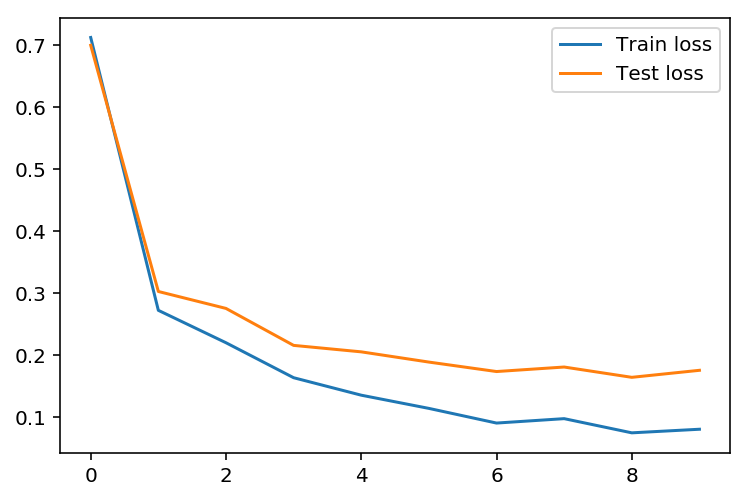

In [68]:
# plot the learning curves
plt.plot(train_errs, label = 'Train loss')
plt.plot(test_errs, label = 'Test loss')
plt.legend();

In [69]:
with tf.Session() as sess:
    saver.restore(sess, './Classfication.ckpt')
    pred = sess.run(y_hat, feed_dict={X:X_test}) # run the prediction layer

In [70]:
classes = (pred > .947).astype(int)
metrics.accuracy_score(y_test, classes)

0.8116753298680528

In [71]:
metrics.confusion_matrix(y_test, classes)

array([[1238,   43],
       [ 428,  792]])

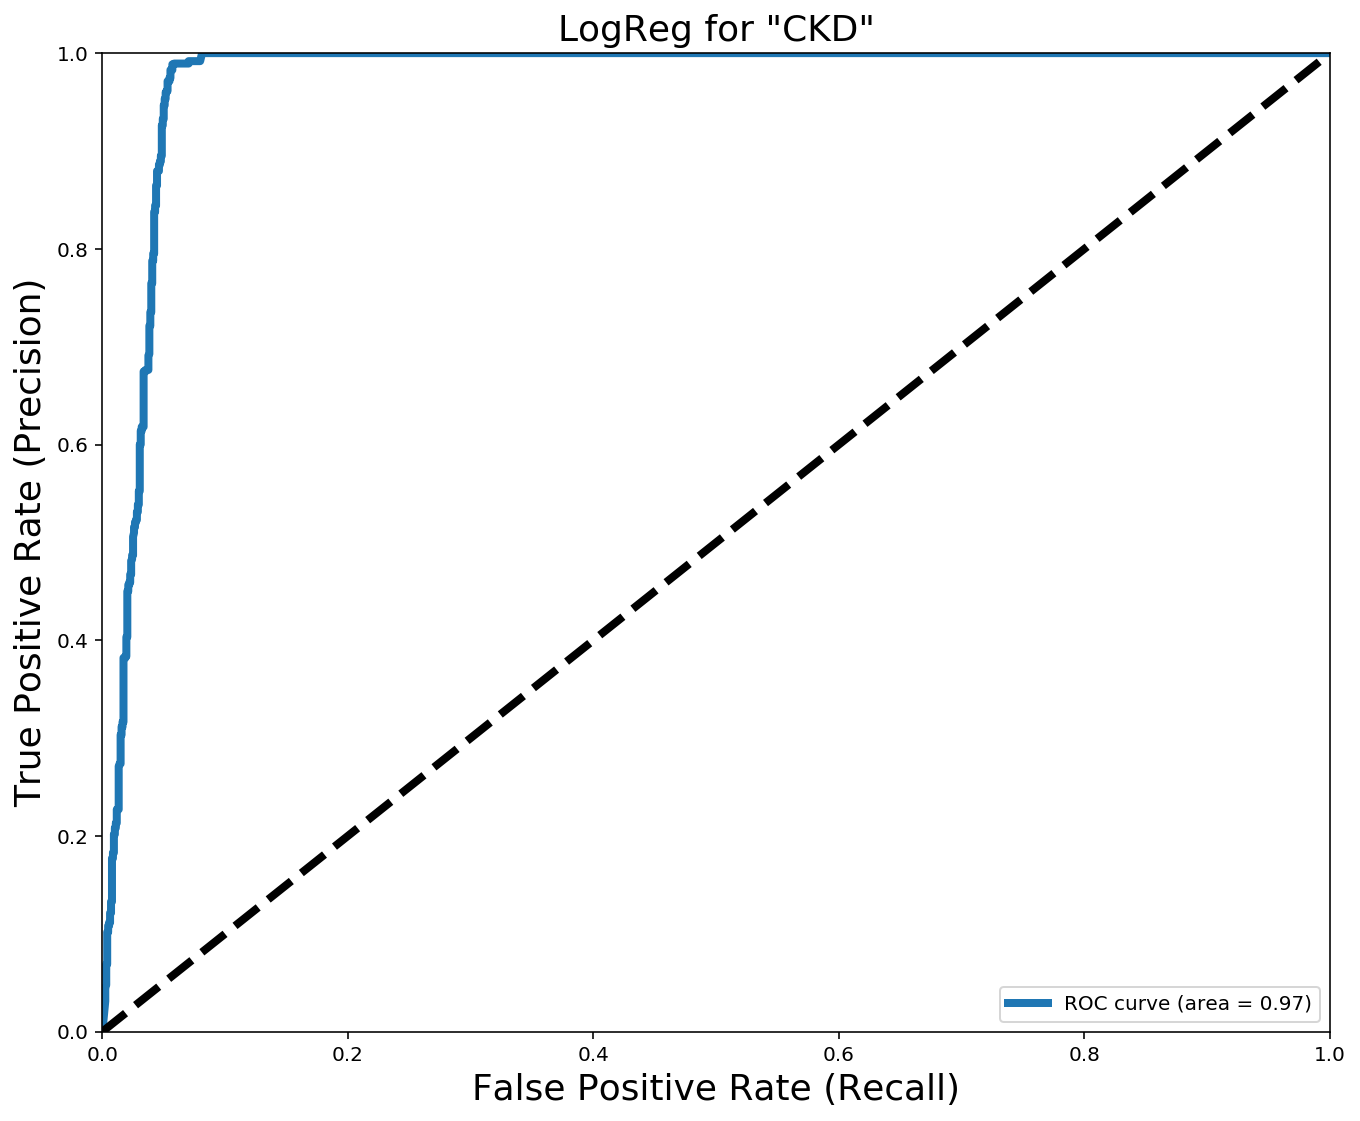

In [72]:
FPR, TPR, threshold = roc_curve(y_test, pred)
ROC_AUC = auc(FPR, TPR)

plt.figure(figsize=[11,9])
plt.plot(FPR, TPR, label='ROC curve (area = %0.2f)' % ROC_AUC, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (Recall)', fontsize=18)
plt.ylabel('True Positive Rate (Precision)', fontsize=18)
plt.title('LogReg for "CKD"', fontsize=18)
plt.legend(loc="lower right")
plt.show()

In [73]:
ss = StandardScaler()
test_clean = ss.fit_transform(test_clean)

In [74]:
test_clean.shape

(116293, 144)

In [75]:
with tf.Session() as sess:
    saver.restore(sess, './Classfication.ckpt')
    pred3 = sess.run(y_hat, feed_dict={X:test_clean}) # run the prediction layer

In [76]:
pred3 = pd.DataFrame(pred3)
pred3['Id'] = [i for i in range(1,116294)]
pred3['WnvPresent'] = pred3[0]
pred3.drop([0],axis=1,inplace=True)
# pred3['WnvPresent'].value_counts()

In [77]:
mask = pred3['WnvPresent'] >0.8
pred3.loc[mask, 'WnvPresent'] = int(1)
pred3.loc[~mask, 'WnvPresent'] = int(0)

In [78]:
pred3['WnvPresent'].value_counts()

0.0    103364
1.0     12929
Name: WnvPresent, dtype: int64

In [79]:
pred3.head()

,Id,WnvPresent
0,1,0.0
1,2,0.0
2,3,0.0
3,4,0.0
4,5,0.0


In [80]:
pred3.to_csv('test_pred_19.csv',index=False)